In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Make DataFrame displays a bit wider and easier to read in notebooks.
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 160)

# Project data locations.
# These mirror the directory structure used throughout the thesis.
DATA = Path("C:/Users/bseis/ABthesis/data")

# Raw weekly CRSP pull (pre-cleaning).
RAW = DATA / "raw" / "crsp_weekly_raw.parquet"

# Processed weekly core panel used in analysis.
CORE = DATA / "processed" / "crsp_weekly_core.parquet"

# Top-1000 weekly universe file.
UNI = DATA / "processed" / "crsp_weekly_universe_top1000.parquet"

In [3]:
core = pd.read_parquet(CORE)
core.info()
core.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3351485 entries, 0 to 3351484
Data columns (total 20 columns):
 #   Column          Dtype         
---  ------          -----         
 0   permno          int64         
 1   permco          Int64         
 2   date            datetime64[ns]
 3   ticker          category      
 4   comnam          category      
 5   ret             float64       
 6   ret_total       float64       
 7   prc_abs         float64       
 8   shrout          float64       
 9   me              float64       
 10  vol             float64       
 11  dollar_vol      float64       
 12  med_dollar_vol  float64       
 13  exchcd          Int64         
 14  shrcd           Int64         
 15  hist_months     int32         
 16  elig_price      bool          
 17  elig_hist       bool          
 18  elig_liq        bool          
 19  in_universe     bool          
dtypes: Int64(3), bool(4), category(2), datetime64[ns](1), float64(8), int32(1), int64(1)
memor

,permno,permco,date,ticker,comnam,ret,ret_total,prc_abs,shrout,me,vol,dollar_vol,med_dollar_vol,exchcd,shrcd,hist_months,elig_price,elig_hist,elig_liq,in_universe
0,10026,7976,1996-12-27,JJSF,J & J SNACK FOODS CORP,-0.017700,-0.017700,13.8750,8750.0,121406250.0,17258.0,2.394548e+05,239454.75000,3,11,0,True,False,True,False
1,10026,7976,1997-01-03,JJSF,J & J SNACK FOODS CORP,-0.049549,-0.049549,13.1875,8750.0,115390625.0,80787.0,1.065379e+06,652416.65625,3,11,1,True,False,True,False
2,10026,7976,1997-01-10,JJSF,J & J SNACK FOODS CORP,-0.033175,-0.033175,12.7500,8750.0,111562500.0,56334.0,7.182585e+05,718258.50000,3,11,2,True,False,True,False
3,10026,7976,1997-01-17,JJSF,J & J SNACK FOODS CORP,-0.107843,-0.107843,11.1250,8750.0,97343750.0,199040.0,2.214320e+06,891818.53125,3,11,3,True,False,True,False
4,10026,7976,1997-01-24,JJSF,J & J SNACK FOODS CORP,0.120881,0.120881,12.7500,8750.0,111562500.0,50995.0,6.501862e+05,718258.50000,3,11,4,True,False,True,False


In [5]:
# Date range & number of unique securities
core["date"] = pd.to_datetime(core["date"])
print(f"Dates: {core['date'].min().date()} → {core['date'].max().date()}")
print(f"Unique permnos: {core['permno'].nunique():,}")

# Weekly frequency check
weeks = core["date"].sort_values().diff().dt.days.value_counts().head()
print("Typical spacing (days):")
print(weeks)

Dates: 1996-12-27 → 2024-12-27
Unique permnos: 3,704
Typical spacing (days):
date
0.0    3350023
7.0       1461
Name: count, dtype: int64


In [7]:
in_uni = core.query("in_universe == True")
print(f"Universe obs: {len(in_uni):,} ({len(in_uni)/len(core):.1%} of total)")
print(f"Universe permnos: {in_uni['permno'].nunique():,}")

# Quick look
in_uni.head()

Universe obs: 1,795,382 (53.6% of total)
Universe permnos: 3,608


,permno,permco,date,ticker,comnam,ret,ret_total,prc_abs,shrout,me,vol,dollar_vol,med_dollar_vol,exchcd,shrcd,hist_months,elig_price,elig_hist,elig_liq,in_universe
1202,10026,7976,2015-09-25,JJSF,J & J SNACK FOODS CORP,0.001443,0.001443,117.85,18676.0,2.200967e+09,321070.0,3.783810e+07,37838099.50,3,11,1202,True,True,True,True
1203,10026,7976,2015-09-25,JJSF,J & J SNACK FOODS CORP,0.000849,0.000849,117.85,18676.0,2.200967e+09,130486.0,1.537778e+07,37838099.50,3,11,1203,True,True,True,True
1204,10026,7976,2015-10-02,JJSF,J & J SNACK FOODS CORP,-0.059533,-0.059533,114.92,18676.0,2.146246e+09,912201.0,1.048301e+08,40220025.46,3,11,1204,True,True,True,True
1205,10026,7976,2015-10-09,JJSF,J & J SNACK FOODS CORP,0.051427,0.051427,120.83,18676.0,2.256621e+09,372519.0,4.501147e+07,40220025.46,3,11,1205,True,True,True,True
1206,10026,7976,2015-10-16,JJSF,J & J SNACK FOODS CORP,0.006622,0.006622,121.63,18676.0,2.271562e+09,263767.0,3.208198e+07,37838099.50,3,11,1206,True,True,True,True


In [9]:
# Now we pick a few random tickers and show their recent history
tickers = core["ticker"].dropna().unique()
sample = np.random.choice(tickers, size=5, replace=False)
display(core.query("ticker in @sample").sort_values(["ticker","date"]).tail(20))

,permno,permco,date,ticker,comnam,ret,ret_total,prc_abs,shrout,me,vol,dollar_vol,med_dollar_vol,exchcd,shrcd,hist_months,elig_price,elig_hist,elig_liq,in_universe
2368042,84009,14711,1999-07-30,SEEK,INFOSEEK CORP,-0.063077,-0.063077,38.06250,31523.0,1.199844e+09,3899277.0,1.484162e+08,2.536058e+08,3,11,165,True,True,True,False
2368043,84009,14711,1999-07-30,SEEK,INFOSEEK CORP,-0.063077,-0.063077,38.06250,31523.0,1.199844e+09,3899277.0,1.484162e+08,2.512456e+08,3,11,166,True,True,True,False
2368044,84009,14711,1999-08-06,SEEK,INFOSEEK CORP,-0.164203,-0.164203,31.81250,31523.0,1.002825e+09,8349474.0,2.656176e+08,2.557745e+08,3,11,167,True,True,True,False
2368045,84009,14711,1999-08-13,SEEK,INFOSEEK CORP,-0.025541,-0.025541,31.00000,31523.0,9.772130e+08,4457019.0,1.381676e+08,2.557745e+08,3,11,168,True,True,True,False
2368046,84009,14711,1999-08-20,SEEK,INFOSEEK CORP,0.014114,0.014114,31.43750,31523.0,9.910043e+08,2912533.0,9.156276e+07,2.557745e+08,3,11,169,True,True,True,False
2368047,84009,14711,1999-08-27,SEEK,INFOSEEK CORP,0.003977,0.003977,31.56250,31523.0,9.949447e+08,2247170.0,7.092630e+07,2.509741e+08,3,11,170,True,True,True,False
2368048,84009,14711,1999-08-27,SEEK,INFOSEEK CORP,-0.028847,-0.028847,31.56250,31523.0,9.949447e+08,769653.0,2.429217e+07,1.484162e+08,3,11,171,True,True,True,False
2368049,84009,14711,1999-09-03,SEEK,INFOSEEK CORP,-0.052831,-0.052831,31.00000,31523.0,9.772130e+08,3350309.0,1.038596e+08,1.484162e+08,3,11,172,True,True,True,False
2368050,84009,14711,1999-09-10,SEEK,INFOSEEK CORP,0.008065,0.008065,31.25000,31523.0,9.850938e+08,1972941.0,6.165441e+07,1.484162e+08,3,11,173,True,True,True,False
2368051,84009,14711,1999-09-17,SEEK,INFOSEEK CORP,-0.080000,-0.080000,28.75000,31523.0,9.062862e+08,2264472.0,6.510357e+07,1.381676e+08,3,11,174,True,True,True,False


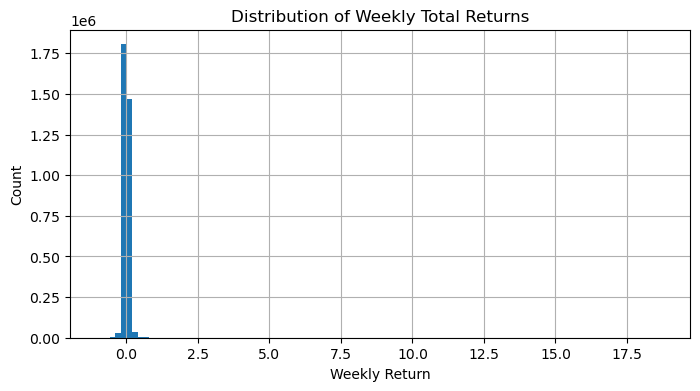

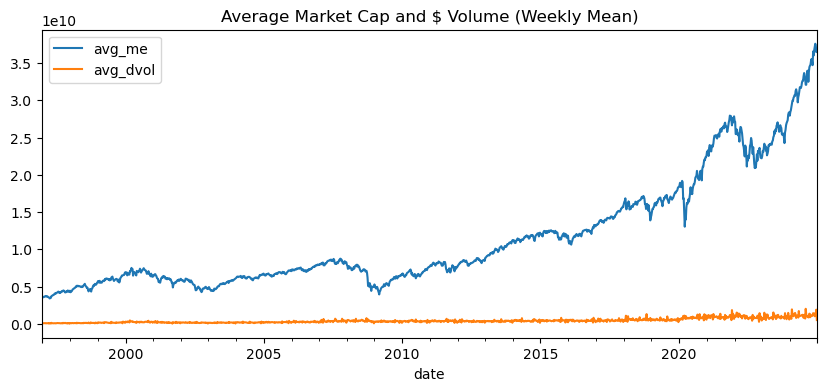

In [11]:
# Distribution of weekly total returns
core["ret_total"].hist(bins=100, figsize=(8,4))
plt.title("Distribution of Weekly Total Returns")
plt.xlabel("Weekly Return")
plt.ylabel("Count")
plt.show()

# Average market cap and dollar volume over time
agg = core.groupby("date", observed=True)[["me","dollar_vol"]].mean().rename(columns={"me":"avg_me","dollar_vol":"avg_dvol"})
agg.plot(figsize=(10,4), title="Average Market Cap and $ Volume (Weekly Mean)")
plt.show()

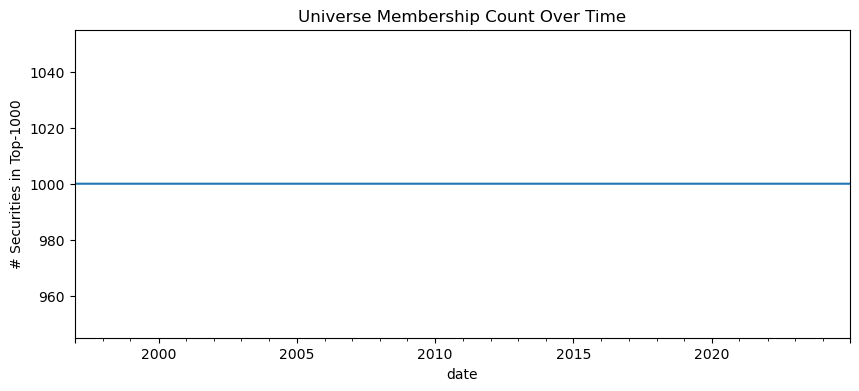

In [13]:
uni = pd.read_parquet(UNI)
uni["date"] = pd.to_datetime(uni["date"])

fig, ax = plt.subplots(figsize=(10,4))
uni.groupby("date")["permno"].count().plot(ax=ax)
ax.set_title("Universe Membership Count Over Time")
ax.set_ylabel("# Securities in Top-1000")
plt.show()

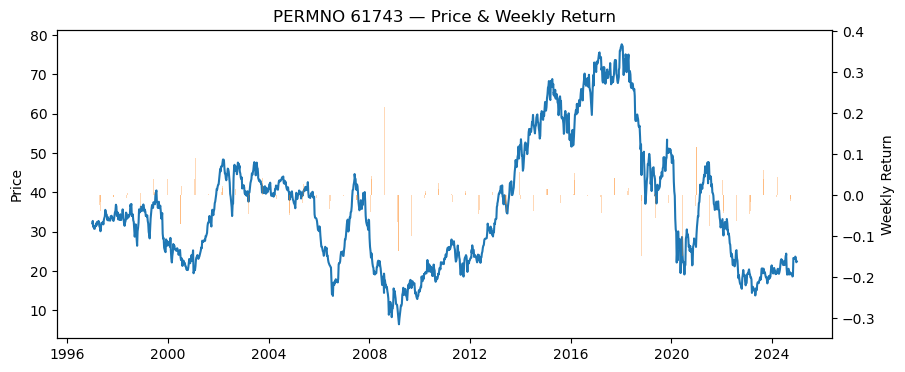

In [15]:
# Pick one permno to visualize price vs return series
perm = int(core["permno"].sample(1).iloc[0])
subset = core.query("permno == @perm").sort_values("date")

fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()

ax1.plot(subset["date"], subset["prc_abs"], color="tab:blue", label="Price")
ax2.bar(subset["date"], subset["ret_total"], color="tab:orange", alpha=0.3, label="Weekly Return")

ax1.set_title(f"PERMNO {perm} — Price & Weekly Return")
ax1.set_ylabel("Price")
ax2.set_ylabel("Weekly Return")
plt.show()